In [7]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [8]:
df=pd.read_csv('nyc_bb_bicyclist_counts.csv',header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
print(df)

            HIGH_T  LOW_T  PRECIP  BB_COUNT
Date                                       
2017-04-01    46.0   37.0    0.00       606
2017-04-02    62.1   41.0    0.00      2021
2017-04-03    63.0   50.0    0.03      2470
2017-04-04    51.1   46.0    1.18       723
2017-04-05    63.0   46.0    0.00      2807
...            ...    ...     ...       ...
2017-10-27    62.1   48.0    0.00      3150
2017-10-28    68.0   55.9    0.00      2245
2017-10-29    64.9   61.0    3.03       183
2017-10-30    55.0   46.0    0.25      1428
2017-10-31    54.0   44.0    0.00      2727

[214 rows x 4 columns]


In [9]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [10]:
print(df)

            HIGH_T  LOW_T  PRECIP  BB_COUNT  MONTH  DAY_OF_WEEK  DAY
Date                                                                
2017-04-01    46.0   37.0    0.00       606      4            5    1
2017-04-02    62.1   41.0    0.00      2021      4            6    2
2017-04-03    63.0   50.0    0.03      2470      4            0    3
2017-04-04    51.1   46.0    1.18       723      4            1    4
2017-04-05    63.0   46.0    0.00      2807      4            2    5
...            ...    ...     ...       ...    ...          ...  ...
2017-10-27    62.1   48.0    0.00      3150     10            4   27
2017-10-28    68.0   55.9    0.00      2245     10            5   28
2017-10-29    64.9   61.0    3.03       183     10            6   29
2017-10-30    55.0   46.0    0.25      1428     10            0   30
2017-10-31    54.0   44.0    0.00      2727     10            1   31

[214 rows x 7 columns]


In [11]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=168
Testing data set length=46


In [13]:
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [14]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  168
Model:                            GLM   Df Residuals:                      161
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11730.
Date:                Sat, 08 Apr 2023   Deviance:                       21836.
Time:                        15:56:45   Pearson chi2:                 2.17e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.1036      0.013    548.238      

In [15]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-03  2600.884812  12.289544    2576.908942    2625.083757
2017-04-04   789.863683   8.215480     773.924656     806.130975
2017-04-06  1114.172257   8.145887    1098.320458    1130.252841
2017-04-17  2809.009389  11.342482    2786.866271    2831.328446
2017-04-19  2128.160740   9.797239    2109.044873    2147.449867
2017-04-20  2263.368820   7.849987    2248.035302    2278.806925
2017-05-04  2510.844833   8.891024    2493.479078    2528.331531
2017-05-05   176.989601   4.419014     168.536998     185.866127
2017-05-08  2546.696008  11.586810    2524.087233    2569.507294
2017-05-09  2606.486461   9.785096    2587.378409    2625.735629
2017-05-12  2375.587045   7.337270    2361.249701    2390.011446
2017-05-19  3164.695266  11.195716    3142.827964    3186.714717
2017-05-22  1520.956354   8.686963    1504.025163    1538.078144
2017-06-01  3020.031143  

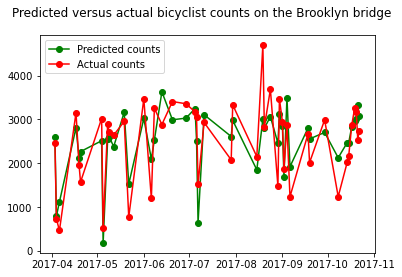

In [16]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

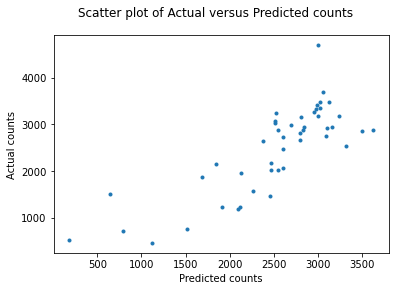

In [17]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()